<h3 style="color:#9d00ff"> Ali Morajabi - 610300104 - HW6 - NNDL</h3>

In [ ]:
!pip install -q gdown

import gdown

file_id = "1ZmYRMfNiZceE6wPdr6O-GXcemuCTcyVX"
output = "dataset.zip"
# دانلود فایل
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1ZmYRMfNiZceE6wPdr6O-GXcemuCTcyVX
From (redirected): https://drive.google.com/uc?id=1ZmYRMfNiZceE6wPdr6O-GXcemuCTcyVX&confirm=t&uuid=b2a45b30-4958-44ff-9345-b9e1ffc38130
To: /content/dataset.zip
100%|██████████| 143M/143M [00:01<00:00, 88.5MB/s]


In [2]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: mnist.pkl               
  inflating: mnistm.pkl              


<hr>
<h4 style="color:#aaff00"> Required Libraries<h4>
<hr>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Subset, DataLoader

from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

<hr>
<h3 style="color:#00ffa5"> Loading & Presetting Dataset </h3>
<hr>

In [4]:
# Loading Mnist
with open('mnist.pkl', 'rb') as f:
    mnist_data = pickle.load(f)

# Loading MNIST-M
with open('mnistm.pkl', 'rb') as f:
    mnistm_data = pickle.load(f)

In [5]:
mnist_train_images = mnist_data[b'images']
mnist_train_labels = mnist_data[b'labels']
mnistm_train_images = mnistm_data[b'images']
mnistm_train_labels = mnistm_data[b'labels']

print("MNIST Train Images Shape:", mnist_train_images.shape)
print("MNIST Train Labels Shape:", mnist_train_labels.shape)
print("MNIST-M Train Images Shape:", mnistm_train_images.shape)
print("MNIST-M Train Labels Shape:", mnistm_train_labels.shape if 'mnistm_train_labels' in locals() else "برچسب‌ها در دسترس نیست")

MNIST Train Images Shape: (70000, 28, 28)
MNIST Train Labels Shape: (70000,)
MNIST-M Train Images Shape: (70000, 28, 28, 3)
MNIST-M Train Labels Shape: (70000,)


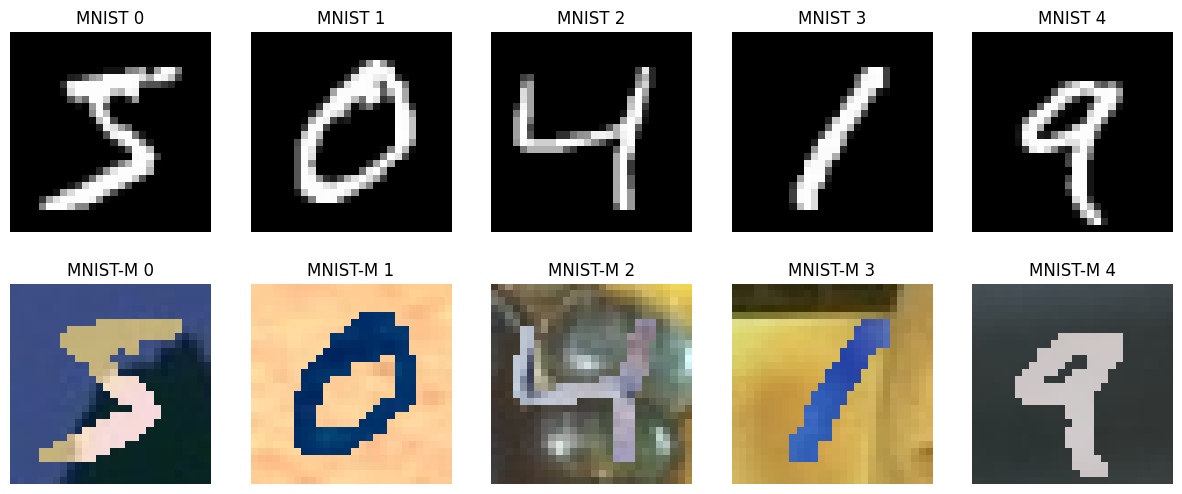

In [ ]:
# Plotting some samples
indices = [0, 1, 2, 3, 4]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(indices):
    axes[0, i].imshow(mnist_train_images[idx], cmap='gray')
    axes[0, i].set_title(f'MNIST {idx}')
    axes[0, i].axis('off')
    axes[1, i].imshow(mnistm_train_images[idx])
    axes[1, i].set_title(f'MNIST-M {idx}')
    axes[1, i].axis('off')
plt.show()


In [ ]:
# Setting
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def mnist_to_rgb(images):
    rgb_images = []
    for img in images:
        img_pil = Image.fromarray(img).convert('RGB')
        rgb_images.append(np.array(img_pil))
    return np.array(rgb_images)

mnist_train_images_rgb = mnist_to_rgb(mnist_train_images)

def apply_transform(images, transform):
    transformed_images = []
    for img in images:
        img_pil = Image.fromarray(img)
        img_transformed = transform(img_pil)
        transformed_images.append(img_transformed)
    return transformed_images

mnist_train_images_transformed = apply_transform(mnist_train_images_rgb, transform)
mnistm_train_images_transformed = apply_transform(mnistm_train_images, transform)

In [ ]:
# Data Split into train and test sets
indices = np.arange(len(mnist_train_images))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

mnist_train_images_split = [mnist_train_images_transformed[i] for i in train_indices]
mnist_test_images_split = [mnist_train_images_transformed[i] for i in test_indices]
mnist_train_labels_split = mnist_train_labels[train_indices]
mnist_test_labels_split = mnist_train_labels[test_indices]

mnistm_train_images_split = [mnistm_train_images_transformed[i] for i in train_indices]
mnistm_test_images_split = [mnistm_train_images_transformed[i] for i in test_indices]

In [ ]:
# Building DataLoader
batch_size = 64

# Turning into tensors
mnist_train_images_tensor = torch.stack(mnist_train_images_split)
mnist_test_images_tensor = torch.stack(mnist_test_images_split)
mnist_train_labels_tensor = torch.tensor(mnist_train_labels_split)
mnist_test_labels_tensor = torch.tensor(mnist_test_labels_split)
mnistm_train_images_tensor = torch.stack(mnistm_train_images_split)
mnistm_test_images_tensor = torch.stack(mnistm_test_images_split)

# DataLoader Definition
mnist_train_dataset = TensorDataset(mnist_train_images_tensor, mnist_train_labels_tensor)
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)

mnist_test_dataset = TensorDataset(mnist_test_images_tensor, mnist_test_labels_tensor)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)

mnistm_train_dataset = TensorDataset(mnistm_train_images_tensor)
mnistm_train_loader = DataLoader(mnistm_train_dataset, batch_size=batch_size, shuffle=True)

mnistm_test_dataset = TensorDataset(mnistm_test_images_tensor)
mnistm_test_loader = DataLoader(mnistm_test_dataset, batch_size=batch_size, shuffle=False)

<hr>
<h3 style="color:#00ffa5"> Classifier </h3>
<hr>

In [ ]:
# Classifier
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.softmax(self.fc2(x))
        return x

model = MNISTClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training on MNIST data
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in mnist_train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(mnist_train_loader):.4f}')

Epoch [1/10], Loss: 1.5700
Epoch [2/10], Loss: 1.5042
Epoch [3/10], Loss: 1.4971
Epoch [4/10], Loss: 1.4925
Epoch [5/10], Loss: 1.4902
Epoch [6/10], Loss: 1.4898
Epoch [7/10], Loss: 1.4879
Epoch [8/10], Loss: 1.4869
Epoch [9/10], Loss: 1.4882
Epoch [10/10], Loss: 1.4858


In [1]:
# Evaluation on MNIST data
model.eval()
mnist_test_preds = []
mnist_test_labels = []
with torch.no_grad():
    for images, labels in mnist_test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        mnist_test_preds.extend(predicted.cpu().numpy())
        mnist_test_labels.extend(labels.cpu().numpy())
mnist_test_accuracy = accuracy_score(mnist_test_labels, mnist_test_preds)
print("Accuracy on MNIST test set: {mnist_test_accuracy:.4f}")

Accuracy on MNIST test set: 0.9843


In [2]:
# Evaluation on MNIST-M data
model.eval()
mnistm_test_preds = []
mnistm_test_labels = []
mnistm_test_images_tensor = torch.stack(mnistm_train_images_transformed)  # Use all MNIST-M data
mnistm_test_dataset = TensorDataset(mnistm_test_images_tensor, torch.tensor(mnistm_train_labels))
mnistm_test_loader = DataLoader(mnistm_test_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    for images, labels in mnistm_test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        mnistm_test_preds.extend(predicted.cpu().numpy())
        mnistm_test_labels.extend(labels.cpu().numpy())
mnistm_accuracy = accuracy_score(mnistm_test_labels, mnistm_test_preds)
print("Accuracy on MNIST-M whole dataset: {mnistm_accuracy:.4f}")

Accuracy on MNIST-M whole dataset: 0.6099


<hr>
<h3 style="color:#00ffa5"> Genertaor, Discriminator and Classifier </h3>
<hr>

In [ ]:
# Generator 
class PixelDA_Generator(nn.Module):
    def __init__(self, z_dim=10, img_channels=3, base_filters=64, n_res_blocks=6):
        super().__init__()
        self.init_conv = nn.Sequential(
            nn.Conv2d(img_channels + z_dim, base_filters, 3, padding=1),
            nn.BatchNorm2d(base_filters),
            nn.ReLU(inplace=True)
        )
        self.res_blocks = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(base_filters, base_filters, 3, padding=1),
                nn.BatchNorm2d(base_filters),
                nn.ReLU(inplace=True),
                nn.Conv2d(base_filters, base_filters, 3, padding=1),
                nn.BatchNorm2d(base_filters),
            )
            for _ in range(n_res_blocks)
        ])
        self.final_conv = nn.Sequential(
            nn.Conv2d(base_filters, img_channels, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x, z):
        z_map = z.view(z.size(0), z.size(1), 1, 1).expand(-1, -1, x.size(2), x.size(3))
        h = torch.cat([x, z_map], dim=1)
        h = self.init_conv(h)
        for blk in self.res_blocks:
            residual = h
            h = blk(h) + residual
            h = F.relu(h, inplace=True)
        return self.final_conv(h)


# Discriminator
class PixelDA_Discriminator(nn.Module):
    def __init__(self, img_channels=3, base_filters=64):
        super().__init__()
        layers = []
        layers += [nn.Conv2d(img_channels, base_filters, 3, padding=1),
                   nn.LeakyReLU(0.2, inplace=True)]
        nf = base_filters
        for _ in range(3):
            layers += [
                nn.Conv2d(nf, nf*2, 3, stride=2, padding=1),
                nn.BatchNorm2d(nf*2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.25)
            ]
            nf *= 2
        self.conv = nn.Sequential(*layers)
        self.fc = nn.Linear(nf * 4 * 4, 1)

    def forward(self, x):
        h = self.conv(x)
        h = h.view(h.size(0), -1)
        return torch.sigmoid(self.fc(h))


# Classifier
class MNISTM_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 48, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(48*8*8, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        return self.net(x)

<hr>
<h3 style="color:#00ffa5"> Loss Definitions </h3>
<hr>

In [ ]:
# Adversarial Loss
bce_loss = nn.BCELoss()

def discriminator_loss(D, real_imgs, fake_imgs):
    # Discriminator Prediction
    pred_real = D(real_imgs)
    pred_fake = D(fake_imgs)
    # Labels
    valid = torch.ones_like(pred_real)
    fake  = torch.zeros_like(pred_fake)
    # Computing BCE
    loss_real = bce_loss(pred_real, valid)
    loss_fake = bce_loss(pred_fake, fake)
    return (loss_real + loss_fake) * 0.5


def generator_adversarial_loss(D, fake_imgs):
    pred_fake = D(fake_imgs)
    valid = torch.ones_like(pred_fake)
    return bce_loss(pred_fake, valid)


# Task (Classification) Loss
ce_loss = nn.CrossEntropyLoss()

def classification_loss(C, real_imgs, real_labels, fake_imgs):
    logits_real = C(real_imgs)
    logits_fake = C(fake_imgs)
    loss_real = ce_loss(logits_real, real_labels)
    loss_fake = ce_loss(logits_fake, real_labels)
    return loss_real + loss_fake

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator, Discriminator and Classifier
G = PixelDA_Generator(z_dim=10).to(device)
D = PixelDA_Discriminator().to(device)
C = MNISTM_Classifier().to(device)

opt_G = optim.Adam(G.parameters(), lr=2.6e-4, betas=(0.5, 0.99))
opt_D = optim.Adam(D.parameters(), lr=2.6e-4, betas=(0.5, 0.99))
opt_C = optim.Adam(C.parameters(), lr=2.6e-4, betas=(0.5, 0.99))

In [ ]:
alpha = 0.011
beta  = 0.01
z_dim = 10
num_epochs = 30

history = {
    "D_loss": [], "G_loss": [],
    "C_train_acc": [], "C_train_acc_fake": [],
    "C_test_acc_mnist": [], "C_test_acc_mnistm": []
}

<hr>
<h3 style="color:#00ffa5"> Training </h3>
<hr>

In [ ]:
# Training Loop
for epoch in range(num_epochs):
    G.train(); D.train(); C.train()
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0

    for (x_s, y_s), (x_t,) in zip(mnist_train_loader, mnistm_train_loader):
        x_s, y_s = x_s.to(device), y_s.to(device)
        x_t = x_t.to(device)
        b = x_s.size(0)

        # Discriminator Training
        z = torch.rand(b, z_dim, device=device).uniform_(-1, 1)
        fake_s = G(x_s, z).detach()
        loss_D = discriminator_loss(D, x_t, fake_s)
        opt_D.zero_grad(); loss_D.backward(); opt_D.step()
        epoch_d_loss += loss_D.item()

        # Generator and Classifier Training
        fake_s = G(x_s, z)
        loss_G_adv = generator_adversarial_loss(D, fake_s)
        loss_task  = classification_loss(C, x_s, y_s, fake_s)
        loss_G = alpha * loss_G_adv + beta * loss_task
        opt_G.zero_grad(); opt_C.zero_grad()
        loss_G.backward()
        opt_G.step(); opt_C.step()
        epoch_g_loss += loss_G.item()

    # Accuracy Evaluation on MNIST train (Real & fake)
    G.eval(); C.eval()
    train_preds, train_labels = [], []
    fake_preds = []

    with torch.no_grad():
        for x_s, y_s in mnist_train_loader:
            x_s, y_s = x_s.to(device), y_s.to(device)
            preds_real = C(x_s).argmax(dim=1).cpu()
            train_preds.extend(preds_real.numpy())
            train_labels.extend(y_s.cpu().numpy())

            z = torch.rand(x_s.size(0), z_dim).uniform_(-1, 1).to(device)
            fake = G(x_s, z)
            preds_fake = C(fake).argmax(dim=1).cpu()
            fake_preds.extend(preds_fake.numpy())

    acc_real = accuracy_score(train_labels, train_preds)
    acc_fake = accuracy_score(train_labels, fake_preds)

    # Evaluation on test set of MNIST
    test_preds_mnist, test_labels_mnist = [], []
    with torch.no_grad():
        for x_s, y_s in mnist_test_loader:
            x_s = x_s.to(device)
            pred = C(x_s).argmax(dim=1).cpu()
            test_preds_mnist.extend(pred.numpy())
            test_labels_mnist.extend(y_s.numpy())
    acc_test_mnist = accuracy_score(test_labels_mnist, test_preds_mnist)

    # Evaluation on test set of MNIST-M
    test_preds_mnistm, test_labels_mnistm = [], []
    with torch.no_grad():
        for x_t, y_t in mnistm_test_loader:
            x_t, y_t = x_t.to(device), y_t.to(device)
            pred = C(x_t).argmax(dim=1).cpu()
            test_preds_mnistm.extend(pred.numpy())
            test_labels_mnistm.extend(y_t.cpu().numpy())
    acc_test_mnistm = accuracy_score(test_labels_mnistm, test_preds_mnistm)

    # Storage and Reporting
    history["D_loss"].append(epoch_d_loss / len(mnist_train_loader))
    history["G_loss"].append(epoch_g_loss / len(mnist_train_loader))
    history["C_train_acc"].append(acc_real)
    history["C_train_acc_fake"].append(acc_fake)
    history["C_test_acc_mnist"].append(acc_test_mnist)
    history["C_test_acc_mnistm"].append(acc_test_mnistm)

    print(f"Epoch {epoch+1}/{num_epochs} | D_loss: {history['D_loss'][-1]:.4f} | G_loss: {history['G_loss'][-1]:.4f} "
          f"| C_acc_real: {acc_real:.4f} | C_acc_fake: {acc_fake:.4f} "
          f"| Test MNIST: {acc_test_mnist:.4f} | Test MNIST-M: {acc_test_mnistm:.4f}")

Epoch 1/30 | D_loss: 0.4468 | G_loss: 0.0334 | C_acc_real: 0.9746 | C_acc_fake: 0.9445 | Test MNIST: 0.9700 | Test MNIST-M: 0.7982
Epoch 2/30 | D_loss: 0.3079 | G_loss: 0.0385 | C_acc_real: 0.9820 | C_acc_fake: 0.9459 | Test MNIST: 0.9767 | Test MNIST-M: 0.8299
Epoch 3/30 | D_loss: 0.2230 | G_loss: 0.0479 | C_acc_real: 0.9875 | C_acc_fake: 0.9673 | Test MNIST: 0.9835 | Test MNIST-M: 0.8574
Epoch 4/30 | D_loss: 0.1766 | G_loss: 0.0534 | C_acc_real: 0.9914 | C_acc_fake: 0.9728 | Test MNIST: 0.9866 | Test MNIST-M: 0.8906
Epoch 5/30 | D_loss: 0.1697 | G_loss: 0.0559 | C_acc_real: 0.9938 | C_acc_fake: 0.9700 | Test MNIST: 0.9899 | Test MNIST-M: 0.9151
Epoch 6/30 | D_loss: 0.1550 | G_loss: 0.0586 | C_acc_real: 0.9939 | C_acc_fake: 0.9705 | Test MNIST: 0.9890 | Test MNIST-M: 0.9150
Epoch 7/30 | D_loss: 0.1466 | G_loss: 0.0590 | C_acc_real: 0.9956 | C_acc_fake: 0.9716 | Test MNIST: 0.9899 | Test MNIST-M: 0.9246
Epoch 8/30 | D_loss: 0.1353 | G_loss: 0.0598 | C_acc_real: 0.9961 | C_acc_fake: 0.9

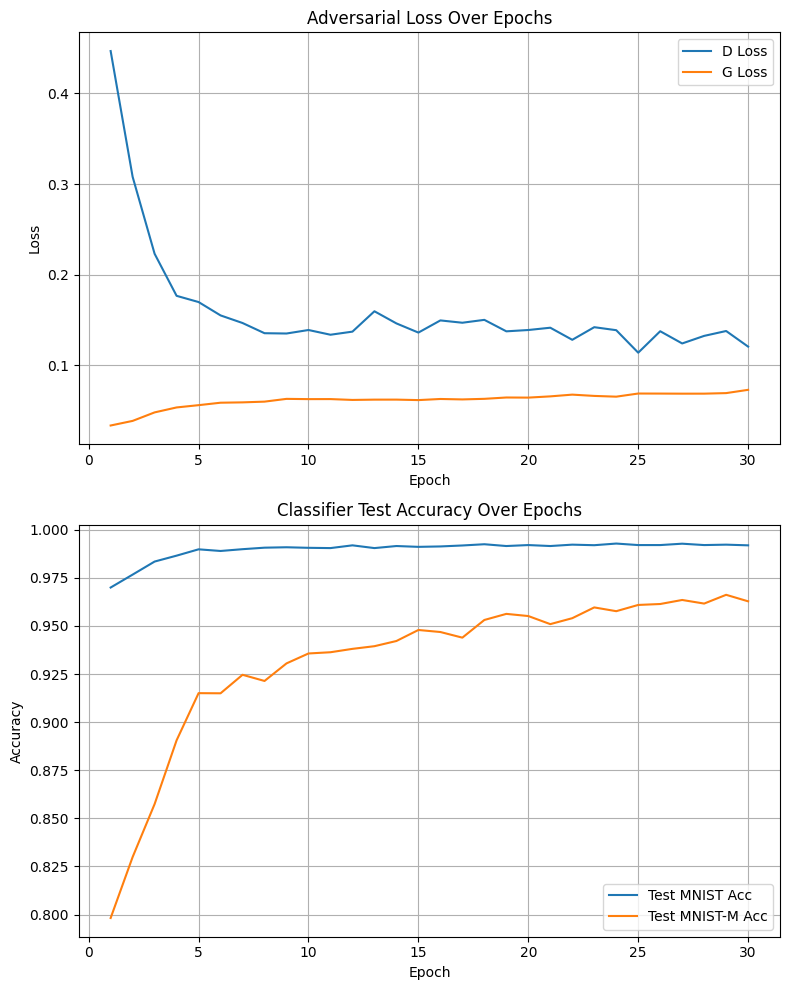

In [ ]:
# Plot Loss and Accuracy Curves
epochs = range(1, len(history['D_loss']) + 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 10))

# Loss
axs[0].plot(epochs, history['D_loss'], label='D Loss')
axs[0].plot(epochs, history['G_loss'], label='G Loss')
axs[0].set_title('Adversarial Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Accuracy
axs[1].plot(epochs, history['C_test_acc_mnist'], label='Test MNIST Acc')
axs[1].plot(epochs, history['C_test_acc_mnistm'], label='Test MNIST-M Acc')
axs[1].set_title('Classifier Test Accuracy Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

<hr>
<h3 style="color:#00ffa5"> Results </h3>
<hr>

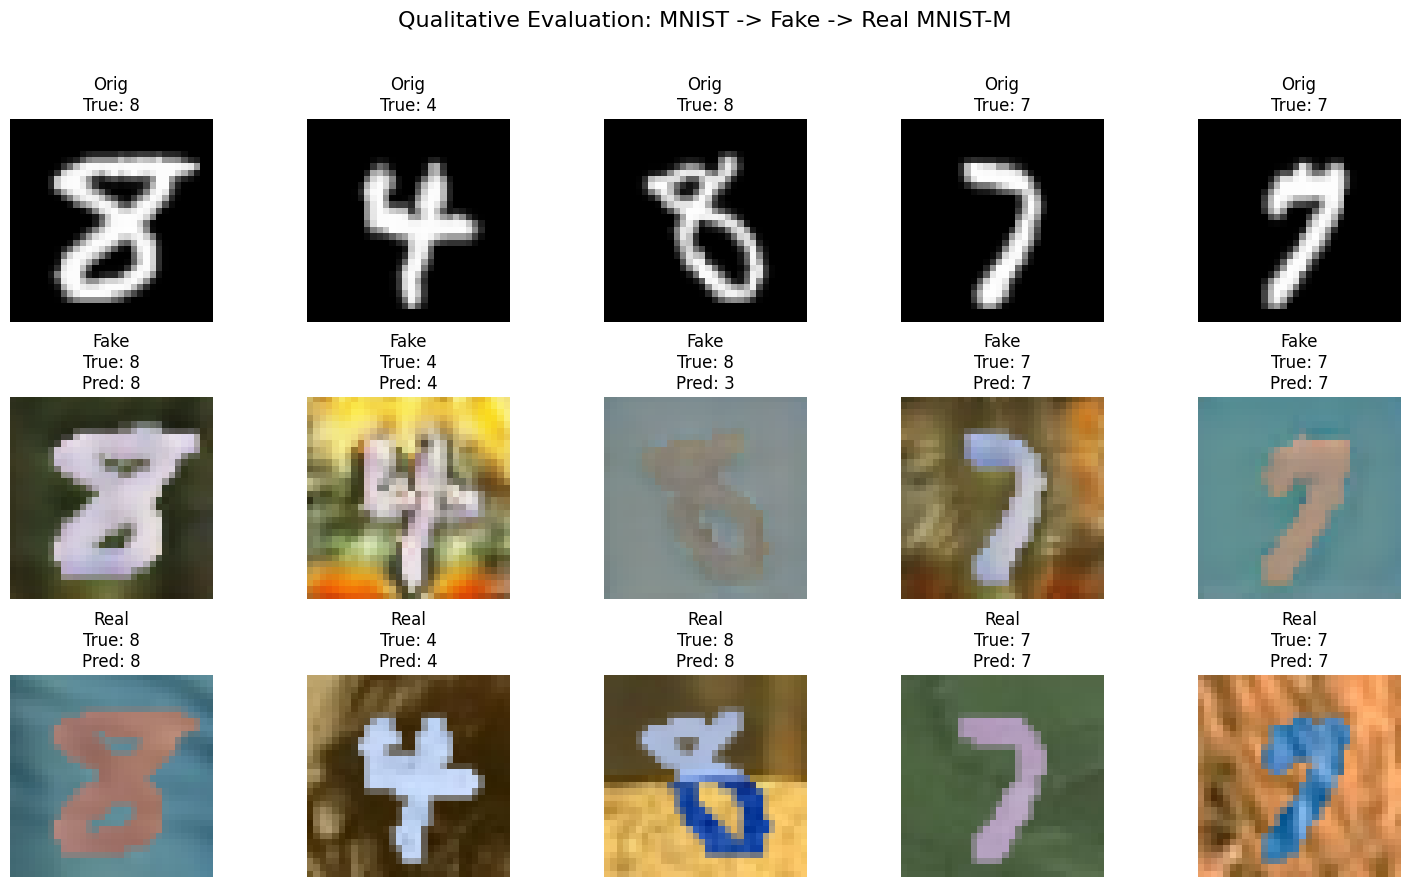

In [ ]:
mnist_images_tensor   = torch.stack(mnist_train_images_transformed)
mnist_labels_tensor   = torch.tensor(mnist_train_labels, dtype=torch.long)
mnistm_images_tensor  = torch.stack(mnistm_train_images_transformed)
mnistm_labels_tensor  = torch.tensor(mnistm_train_labels, dtype=torch.long)

full_mnist_dataset  = TensorDataset(mnist_images_tensor,  mnist_labels_tensor)
full_mnistm_dataset = TensorDataset(mnistm_images_tensor, mnistm_labels_tensor)

mnist_test_dataset  = Subset(full_mnist_dataset,  test_indices)
mnistm_test_dataset = Subset(full_mnistm_dataset, test_indices)

mnist_test_loader   = DataLoader(mnist_test_dataset,  batch_size=len(test_indices), shuffle=False)
mnistm_test_loader  = DataLoader(mnistm_test_dataset, batch_size=len(test_indices), shuffle=False)

sample_indices = test_indices[:5]

def to_img(tensor):
    img = tensor.squeeze().detach().cpu()
    img = (img + 1) / 2
    return img.permute(1, 2, 0).numpy()

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for i, idx in enumerate(sample_indices):
    # MNIST REAL
    x_s, y_s = full_mnist_dataset[idx]
    x_s = x_s.to(device).unsqueeze(0)
    # FAKE
    z = torch.rand(1, z_dim, device=device).uniform_(-1, 1)
    fake = G(x_s, z)
    pred_fake = C(fake).argmax(dim=1).item()
    # MNIST-M REAL
    x_t, y_t = full_mnistm_dataset[idx]
    x_t = x_t.to(device).unsqueeze(0)
    pred_t = C(x_t).argmax(dim=1).item()

    axes[0, i].imshow(to_img(x_s))
    axes[0, i].set_title(f"Orig\nTrue: {y_s}")
    axes[0, i].axis('off')

    axes[1, i].imshow(to_img(fake))
    axes[1, i].set_title(f"Fake\nTrue: {y_s}\nPred: {pred_fake}")
    axes[1, i].axis('off')

    axes[2, i].imshow(to_img(x_t))
    axes[2, i].set_title(f"Real\nTrue: {y_t}\nPred: {pred_t}")
    axes[2, i].axis('off')

plt.suptitle("Qualitative Evaluation: MNIST -> Fake -> Real MNIST-M", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
